# Sistem Rekomendasi: Rekomendasi Buku Berdasarkan Data Buku Yang Telah Dibaca Oleh Warga di Negara Kanada
<hr>

### *Oleh: [Panji Arlin Saputra](https://www.dicoding.com/users/panjiarlins)*
### *Proyek Akhir: Machine Learning Terapan Dicoding*
<hr>

## **Pendahuluan**
Pada proyek ini, topik yang dibahas adalah mengenai rekomendasi buku berdasarkan data buku yang telah dibaca oleh warga di negara Kanada. Proyek ini dibuat untuk proyek akhir - Machine Learning Terapan Dicoding.

# **1. Mengimpor pustaka/modul python yang dibutuhkan**

In [1]:
# Impor pustaka/ modul
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np 
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

# **2. Mempersiapkan Dataset**

## **2.1 Menyiapkan kredensial akun Kaggle**

In [2]:
# Membuat folder .kaggle di dalam folder root
!rm -rf ~/.kaggle && mkdir ~/.kaggle/

# Menyalin berkas kaggle.json pada direktori aktif saat ini ke folder .kaggle
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

## **2.2 Mengunduh dan Menyiapkan Dataset**

Informasi Dataset:

| Jenis | Keterangan |
| ----- | ----- |
| Sumber | [Kaggle Dataset - Book-Crossing: User review ratings](https://www.kaggle.com/ruchi798/bookcrossing-dataset) |
| Kategori | Seni dan Hiburan, Komunitas Online, Sastra |
| Jenis dan Ukuran Berkas | CSV (600 MB) |

In [3]:
# Mengunduh dataset menggunakan Kaggle CLI
!kaggle datasets download ruchi798/bookcrossing-dataset

 75% 57.0M/76.1M [00:00<00:00, 71.0MB/s]
100% 76.1M/76.1M [00:00<00:00, 130MB/s] 


In [4]:
# Mengekstrak berkas zip ke direktori aktif saat ini
!unzip /content/bookcrossing-dataset.zip

Archive:  /content/bookcrossing-dataset.zip
  inflating: Book reviews/Book reviews/BX-Book-Ratings.csv  
  inflating: Book reviews/Book reviews/BX-Users.csv  
  inflating: Book reviews/Book reviews/BX_Books.csv  
  inflating: Books Data with Category Language and Summary/Preprocessed_data.csv  


# **3. Pemahaman Data (_Data Understanding_)**

## **3.1 Memuat Data pada sebuah Dataframe menggunakan pandas**

In [5]:
# Untuk memuat himpunan data
path = '/content/Books Data with Category Language and Summary/Preprocessed_data.csv'
df = pd.read_csv(path)

In [6]:
# Menampilkan sample data pada dataset
df.sample(5)

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country
731928,731928,254676,"chicago, illinois,",34.7439,0451206533,0,A Moment in Time,Judith Gould,2002.0,Signet Book,http://images.amazon.com/images/P/0451206533.0...,http://images.amazon.com/images/P/0451206533.0...,http://images.amazon.com/images/P/0451206533.0...,9,9,9,chicago,"illinois,",NaN
687843,687843,36836,"raleigh, north carolina, usa",56.0000,0813327024,0,Am I A Murderer?: Testament of a Jewish Ghetto...,Calel Perechodnik,1996.0,Westview Press,http://images.amazon.com/images/P/0813327024.0...,http://images.amazon.com/images/P/0813327024.0...,http://images.amazon.com/images/P/0813327024.0...,The diary of a young Polish Jew reveals his at...,en,['Religion'],raleigh,north carolina,usa
948876,948876,171118,"toronto, ontario, canada",47.0000,0425050947,0,Win/Negotiation,Tessa Warschaw,1981.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425050947.0...,http://images.amazon.com/images/P/0425050947.0...,http://images.amazon.com/images/P/0425050947.0...,9,9,9,toronto,ontario,canada
883598,883598,113955,"webster, new york, usa",16.0000,0380785153,10,"A Picture's Worth (Cyber.Kdz, No 2)",Bruce Balan,1997.0,Harpercollins Childrens Books,http://images.amazon.com/images/P/0380785153.0...,http://images.amazon.com/images/P/0380785153.0...,http://images.amazon.com/images/P/0380785153.0...,9,9,9,webster,new york,usa
837603,837603,180651,"coventry, england, united kingdom",54.0000,074932208X,0,Swan,Naomi Campbell,1996.0,Butterworth-Heinemann,http://images.amazon.com/images/P/074932208X.0...,http://images.amazon.com/images/P/074932208X.0...,http://images.amazon.com/images/P/074932208X.0...,Swan is the world&#39;s most successful superm...,en,['Models (Persons)'],coventry,england,united kingdom


## **3.2 Uraian variabel pada dataset**

In [7]:
# Memuat informasi dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031175 entries, 0 to 1031174
Data columns (total 19 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Unnamed: 0           1031175 non-null  int64  
 1   user_id              1031175 non-null  int64  
 2   location             1031175 non-null  object 
 3   age                  1031175 non-null  float64
 4   isbn                 1031175 non-null  object 
 5   rating               1031175 non-null  int64  
 6   book_title           1031175 non-null  object 
 7   book_author          1031175 non-null  object 
 8   year_of_publication  1031175 non-null  float64
 9   publisher            1031175 non-null  object 
 10  img_s                1031175 non-null  object 
 11  img_m                1031175 non-null  object 
 12  img_l                1031175 non-null  object 
 13  Summary              1031175 non-null  object 
 14  Language             1031175 non-null  object 
 15

In [8]:
# Memuat deskripsi kolom pada dataframe
df.describe().round(2)

,Unnamed: 0,user_id,age,rating,year_of_publication
count,1031175.00,1031175.00,1031175.00,1031175.00,1031175.00
mean,515587.00,140594.37,36.43,2.84,1995.28
std,297674.73,80524.44,10.35,3.85,7.31
min,0.00,2.00,5.00,0.00,1376.00
25%,257793.50,70415.00,31.00,0.00,1992.00
50%,515587.00,141210.00,34.74,0.00,1997.00
75%,773380.50,211426.00,41.00,7.00,2001.00
max,1031174.00,278854.00,99.00,10.00,2008.00


## **3.3 Menangani _missing value_**

In [9]:
# Menghitung jumlah data yang kosong pada setiap kolom
df.isna().sum()

Unnamed: 0                 0
user_id                    0
location                   0
age                        0
isbn                       0
rating                     0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
img_s                      0
img_m                      0
img_l                      0
Summary                    0
Language                   0
Category                   0
city                   14103
state                  22798
country                35374
dtype: int64

In [10]:
# Menghapus data yang memiliki nilai kosong
df = df.dropna()

# **4. Persiapan Data (Data Preparation)**

## **4.1 Mengatasi masalah data yang tidak diperlukan dengan menghapus kolom tersebut**

In [11]:
# Menghapus kolom yang tidak diperlukan
df.drop(['Unnamed: 0', 'location', 'img_s', 'img_m', 'img_l', 'Summary', 'city', 'state'], axis=1, inplace=True)
df.sample(5)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,user_id,age,isbn,rating,book_title,book_author,year_of_publication,publisher,Language,Category,country
814743,84024,37.0,0380802821,0,Mood Swings to Murder: A Bel Barrett Mystery,Jane Isenberg,2000.0,Avon,9,9,usa
579235,153662,44.0,067172066X,0,Warrior's Apprentice,Lois McMaster Bujold,1991.0,Baen,en,['Fiction'],usa
933871,155219,29.0,0385319371,0,A Cup of Light,NICOLE MONES,2002.0,Delacorte Press,en,['Fiction'],usa
223147,4017,48.0,0399142789,10,Conversations with God : An Uncommon Dialogue ...,Neale Donald Walsch,1996.0,Putnam Publishing Group,9,9,usa
306522,171118,47.0,051511331X,0,November of the Heart,LaVyrle Spencer,1995.0,Jove Books,9,9,canada


## **4.2 Pembersihan data pada setiap kolom**

### **4.2.1 Kolom country**

In [12]:
# Menghitung sebaran nilai pada variabel country
df['country'].value_counts()

usa                742313
canada              92461
united kingdom      30454
germany             27255
australia           18191
                    ...  
el salvador             1
álava, spain            1
cananda                 1
onondaga nation         1
csa                     1
Name: country, Length: 394, dtype: int64

In [13]:
# Memfilter semua pengguna yang berasal dari negara Kanada
df = df.loc[df['country'].str.contains('canada')]
df.sample(5)

,user_id,age,isbn,rating,book_title,book_author,year_of_publication,publisher,Language,Category,country
33867,164956,44.0,0440241413,0,Confessions of a Shopaholic,SOPHIE KINSELLA,2003.0,Dell,en,['Fiction'],canada
588272,124079,24.0,0451455509,0,Dark Love,Nancy A. Collins,1996.0,Roc,9,9,canada
555481,69042,55.0,0345306252,0,Dilvish the Damned,Roger Zelazny,1982.0,Ballantine Books,en,['Fantasy'],canada
619848,77229,35.0,077109860X,8,The Tin Flute (New Canadian Library),Gabrielle Roy,1995.0,New Canadian Library,9,9,canada
514,274167,52.0,0440234743,0,The Testament,John Grisham,1999.0,Dell,en,['Fiction'],canada


### **4.2.2 Kolom rating**

    jumlah sampel  persentase
0           57244        61.9
8            8979         9.7
7            6907         7.5
10           5384         5.8
9            5122         5.5
5            4135         4.5
6            3195         3.5
4             737         0.8
3             479         0.5
2             210         0.2
1             116         0.1


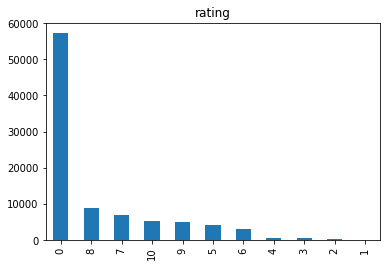

In [14]:
# Menghitung sebaran jumlah nilai pada variabel rating
count = df['rating'].value_counts()
percent = 100 * df['rating'].value_counts(normalize=True)
print(pd.DataFrame({'jumlah sampel':count, 'persentase':percent.round(1)}))
count.plot(kind='bar', title='rating');

In [15]:
# Memfilter semua rating agar nilai rating yang diambil berkisar di angka (1 - 10)
df = df.loc[df['rating'] != 0]

# Mengubah rating menjadi nilai float
df['rating'] = df['rating'].values.astype(np.float32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


      jumlah sampel  persentase
8.0            8979        25.5
7.0            6907        19.6
10.0           5384        15.3
9.0            5122        14.5
5.0            4135        11.7
6.0            3195         9.1
4.0             737         2.1
3.0             479         1.4
2.0             210         0.6
1.0             116         0.3


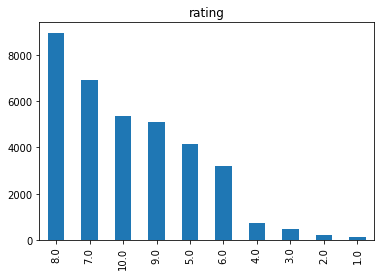

In [16]:
# Menghitung lagi sebaran jumlah nilai pada variabel rating
count = df['rating'].value_counts()
percent = 100 * df['rating'].value_counts(normalize=True)
print(pd.DataFrame({'jumlah sampel':count, 'persentase':percent.round(1)}))
count.plot(kind='bar', title='rating');

### **4.2.3 Kolom Language**

In [17]:
# Menampilkan nilai yang ada pada variabel Language
df['Language'].unique()

array(['en', '9', 'fr', 'es', 'da', 'it', 'ru', 'el', 'nl', 'pt', 'de',
       'zh-TW'], dtype=object)

In [18]:
# Menghapus semua data pada variable Language yang memiliki nilai yang aneh
df = df[df['Language'] != '9']

In [19]:
# Menampilkan lagi nilai yang ada pada variabel Language
df['Language'].unique()

array(['en', 'fr', 'es', 'da', 'it', 'ru', 'el', 'nl', 'pt', 'de',
       'zh-TW'], dtype=object)

### **4.2.4 Kolom Category**

In [20]:
# Menampilkan nilai yang ada pada variabel Category
df['Category'].unique()[:50]

array(["['Actresses']", "['1940-1949']", "['Fiction']", "['Nature']",
       "['Humor']", "['Juvenile Fiction']", "['History']",
       "['Health & Fitness']", "['FICTION']", "['Science']",
       "['Conduct of life']", "['Americans']",
       "['Biography & Autobiography']", "['American fiction']",
       "['Diary fiction']", "['Self-Help']", "['Social Science']",
       "['Adolescence']", "['Dune (Imaginary place)']",
       "['London (England)']", "['Fairy tales']", "['Jews']",
       "['Fantasy fiction, English']", "['Arctic regions']",
       "['Fantasy comic books, strips, etc']", "['Aerospace engineers']",
       "['Juvenile Nonfiction']", "['Computers']",
       "['American literature']", "['Businessmen']",
       "['Body, Mind & Spirit']", "['Fantasy fiction']", "['Criminals']",
       "['Adulteresses']", "['Business & Economics']",
       "['Rapture (Christian eschatology)']",
       "['Detective and mystery stories']", "['Horror tales']",
       "['Feminists']", "['Political

In [21]:
# Menghapus semua data pada variable Category yang memiliki nilai yang aneh
df = df[df['Category'].str.startswith('[') & df['Category'].str.endswith(']')]

## **4.3 Menampilkan informasi dataset**

In [22]:
# Memastikan tidak ada data duplikasi
df.duplicated().sum()

0

In [23]:
# Mengecek total baris dan kolom dari dataset
df.shape

(21750, 11)

In [24]:
# Menampilkan informasi data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21750 entries, 1 to 1031136
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              21750 non-null  int64  
 1   age                  21750 non-null  float64
 2   isbn                 21750 non-null  object 
 3   rating               21750 non-null  float32
 4   book_title           21750 non-null  object 
 5   book_author          21750 non-null  object 
 6   year_of_publication  21750 non-null  float64
 7   publisher            21750 non-null  object 
 8   Language             21750 non-null  object 
 9   Category             21750 non-null  object 
 10  country              21750 non-null  object 
dtypes: float32(1), float64(2), int64(1), object(7)
memory usage: 1.9+ MB


In [25]:
print('Jumlah buku:', len(df.isbn.unique()))
print('Jumlah pengguna:',len(df.user_id.unique()))
print('Jumlah rating', len(df))

Jumlah buku: 14035
Jumlah pengguna: 4674
Jumlah rating 21750


## **4.4 _Encoding_ variabel user_id dan isbn**

In [26]:
# Mengubah user_id menjadi list tanpa nilai yang sama
user_id = df['user_id'].unique().tolist()
print('list user_id: ', user_id)
 
# Melakukan encoding user_id
user_to_user_encoded = {x: i for i, x in enumerate(user_id)}
print('encoding user_id : ', user_to_user_encoded)
 
# Melakukan proses encoding angka ke ke user_id
user_encoded_to_user = {i: x for i, x in enumerate(user_id)}
print('encoding angka ke user_id: ', user_encoded_to_user)

list user_id:  [8, 67544, 123629, 200273, 210926, 219008, 263325, 152827, 122440, 233731, 6242, 14449, 36907, 95392, 105517, 174326, 218421, 98758, 164027, 13221, 14049, 21404, 26371, 26979, 28804, 33875, 36417, 37293, 37950, 41757, 42962, 45666, 51803, 54118, 59994, 67636, 70153, 70222, 71162, 74910, 76901, 86123, 89867, 100452, 122086, 124079, 124827, 126693, 127024, 133414, 136237, 138844, 148051, 150915, 159720, 169563, 183963, 201137, 201969, 205350, 215298, 228790, 232555, 235506, 243075, 243491, 250153, 258023, 261015, 270051, 270131, 274692, 14801, 22463, 30035, 42458, 69967, 70594, 100668, 153211, 161789, 164323, 174700, 201776, 204591, 217318, 234162, 242499, 264600, 267377, 32148, 59172, 80375, 155823, 191049, 201870, 227925, 240660, 43246, 88412, 235867, 101606, 144668, 4225, 7409, 9417, 29981, 47971, 81138, 117781, 120935, 130837, 171118, 200226, 201526, 201697, 209160, 216861, 229440, 245371, 252222, 127066, 198334, 157475, 242878, 39440, 43807, 21540, 70065, 128742, 1674

In [27]:
# Mengubah isbn menjadi list tanpa nilai yang sama
book_isbn = df['isbn'].unique().tolist()
 
# Melakukan proses encoding isbn
isbn_to_isbn_encoded = {x: i for i, x in enumerate(book_isbn)}
print('encoded isbn:', isbn_to_isbn_encoded)
 
# Melakukan proses encoding angka ke isbn
isbn_encoded_to_isbn = {i: x for i, x in enumerate(book_isbn)}
print('encoded angka ke isbn:', isbn_encoded_to_isbn)

encoded isbn: {'0002005018': 0, '0060973129': 1, '074322678X': 2, '1575663937': 3, '1881320189': 4, '0440234743': 5, '0452264464': 6, '0609804618': 7, '0439095026': 8, '0971880107': 9, '0345402871': 10, '0345417623': 11, '0425099148': 12, '0375759778': 13, '0425163091': 14, '0446310786': 15, '0449005615': 16, '067176537X': 17, '0671888587': 18, '0553582747': 19, '0425182908': 20, '042518630X': 21, '0440223571': 22, '0842342702': 23, '0440225701': 24, '0345260317': 25, '1853260053': 26, '0140067477': 27, '0345465083': 28, '1558531025': 29, '0441783589': 30, '0316769487': 31, '0679429220': 32, '0671867156': 33, '0312252617': 34, '0451166892': 35, '067976397X': 36, '0786868716': 37, '0671864769': 38, '0446608653': 39, '0451208080': 40, '0553584383': 41, '0380619458': 42, '0425184226': 43, '0375500766': 44, '0060929790': 45, '0060976845': 46, '0446601640': 47, '0345425294': 48, '0553583468': 49, '0385336772': 50, '0060801263': 51, '0061030147': 52, '0385337639': 53, '0330332775': 54, '0486

In [28]:
# Mapping normalized user_id ke dataset
df['user_encoded'] = df['user_id'].map(user_to_user_encoded)
 
# Mapping encoded isbn ke dataset
df['isbn_encoded'] = df['isbn'].map(isbn_to_isbn_encoded)

df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,age,isbn,rating,book_title,book_author,year_of_publication,publisher,Language,Category,country,user_encoded,isbn_encoded
1,8,34.7439,0002005018,5.0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,['Actresses'],canada,0,0
5,67544,30.0000,0002005018,8.0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,['Actresses'],canada,1,0
9,123629,34.7439,0002005018,9.0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,['Actresses'],canada,2,0
11,200273,34.7439,0002005018,8.0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,['Actresses'],canada,3,0
12,210926,34.7439,0002005018,9.0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,['Actresses'],canada,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029956,277929,34.0000,0843932430,7.0,Viking Passion,Flora Speer,1992.0,Leisure Books,en,['Fiction'],canada,2746,14030
1030034,278221,32.0000,074341702X,7.0,The Wonder of Girls : Understanding the Hidden...,Michael Gurian,2002.0,Atria,en,['Family & Relationships'],canada,860,14031
1030037,278221,32.0000,1889613010,10.0,Organon of the Medical Art,Samuel Hahnemann,2000.0,Birdcage Books,en,['Medical'],canada,860,14032
1030039,278248,34.7439,080506723X,8.0,Desert Burial: A Novel,Brian Littlefair,2002.0,Henry Holt & Company,en,['Fiction'],canada,4672,14033


## **4.5 Menormalisasi data rating dan melakukan pembagian data pada dataset**

In [29]:
# Nilai minimum rating
min_rating = min(df['rating'])
 
# Nilai maksimal rating
max_rating = max(df['rating'])

# Mengacak dataset
df = df.sample(frac=1, random_state=42)

# Membuat variabel x untuk mencocokkan data user dan isbn menjadi satu value
x = df[['user_encoded', 'isbn_encoded']].values
 
# Membuat variabel y untuk menyimpan hasil normalisasi data rating
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
 
# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

## **4.6 Membuat dataset buku**

In [30]:
# Menghapus duplikasi pada data buku
preparation = df
preparation = preparation.drop_duplicates('isbn')
preparation

,user_id,age,isbn,rating,book_title,book_author,year_of_publication,publisher,Language,Category,country,user_encoded,isbn_encoded
70787,3282,52.0000,0451205421,8.0,The Door to December,Dean R. Koontz,2002.0,Signet Book,en,['Fiction'],canada,987,341
270537,6242,34.7439,0452272726,5.0,The Eye in the Door,Pat Barker,1995.0,Plume Books,en,['Fiction'],canada,10,2077
506837,223143,34.7439,0449908585,8.0,The Happy Isles of Oceania: Paddling the Pacific,Paul Theroux,1993.0,Ballantine Books,en,['Travel'],canada,1958,5000
320396,43246,36.0000,0140067779,9.0,Obasan,Joy Kogawa,1983.0,Penguin Books,en,['Fiction'],canada,98,2632
363472,246480,34.7439,0553581554,2.0,The Killing Game: Only One Can Win...and the L...,Iris Johansen,2000.0,Bantam Books,en,['Fiction'],canada,2856,3149
...,...,...,...,...,...,...,...,...,...,...,...,...,...
661022,249695,35.0000,067156756X,6.0,FOOD : FOOD,Susan Powter,1996.0,Pocket,en,['Health & Fitness'],canada,343,7387
779168,64015,28.0000,1862040761,7.0,The Elements of Natural Magic (The elements of),Marian Green,1997.0,Element Books Ltd.,en,['Philosophy'],canada,2213,9436
264767,26057,18.0000,0767915593,7.0,Straight Talking : A Novel,JANE GREEN,2003.0,Broadway,en,['Fiction'],canada,362,2002
1021780,260183,25.0000,0471528986,9.0,Conquering Math Phobia : A Painless Primer,Calvin C. Clawson,1991.0,Wiley,en,['Mathematics'],canada,753,13860


In [31]:
# Menginsialisasikkan variabel buku
book_isbn = preparation['isbn'].tolist()
book_title = preparation['book_title'].tolist()
book_author = preparation['book_author'].tolist()
book_year_of_publication = preparation['year_of_publication'].tolist()
book_publisher = preparation['publisher'].tolist()
book_language = preparation['Language'].tolist()
book_category = preparation['Category'].tolist()

In [32]:
# Membuat dataframe buku
books = pd.DataFrame({
    'isbn': book_isbn,
    'title': book_title,
    'author': book_author,
    'year_of_publication': book_year_of_publication,
    'publisher': book_publisher,
    'language': book_language,
    'category': book_category
})
data = books
books

,isbn,title,author,year_of_publication,publisher,language,category
0,0451205421,The Door to December,Dean R. Koontz,2002.0,Signet Book,en,['Fiction']
1,0452272726,The Eye in the Door,Pat Barker,1995.0,Plume Books,en,['Fiction']
2,0449908585,The Happy Isles of Oceania: Paddling the Pacific,Paul Theroux,1993.0,Ballantine Books,en,['Travel']
3,0140067779,Obasan,Joy Kogawa,1983.0,Penguin Books,en,['Fiction']
4,0553581554,The Killing Game: Only One Can Win...and the L...,Iris Johansen,2000.0,Bantam Books,en,['Fiction']
...,...,...,...,...,...,...,...
14030,067156756X,FOOD : FOOD,Susan Powter,1996.0,Pocket,en,['Health & Fitness']
14031,1862040761,The Elements of Natural Magic (The elements of),Marian Green,1997.0,Element Books Ltd.,en,['Philosophy']
14032,0767915593,Straight Talking : A Novel,JANE GREEN,2003.0,Broadway,en,['Fiction']
14033,0471528986,Conquering Math Phobia : A Painless Primer,Calvin C. Clawson,1991.0,Wiley,en,['Mathematics']


# **5. Pembuatan Model**

## **5.1 _Content Based Filtering_**

In [33]:
# Inisialisasi TfidfVectorizer
tfidf = TfidfVectorizer()

# Melakukan perhitungan idf pada data category
tfidf.fit(data['category'])
print(len(tfidf.get_feature_names()))

# Mapping array dari fitur index integer ke fitur nama
tfidf.get_feature_names()

1288


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['1834',
 '1903',
 '1914',
 '1918',
 '1939',
 '1940',
 '1945',
 '1949',
 '1961',
 '1975',
 '1991',
 '20th',
 '2e',
 'abandoned',
 'abduction',
 'ability',
 'abnormalities',
 'aboriginal',
 'abortion',
 'abuse',
 'abused',
 'abusive',
 'accelerated',
 'accident',
 'accidental',
 'accidents',
 'accountants',
 'accounting',
 'action',
 'activities',
 'actors',
 'actresses',
 'actualisation',
 'actualization',
 'addams',
 'adjustment',
 'administration',
 'admirals',
 'admission',
 'adolescence',
 'adopted',
 'adoptees',
 'adult',
 'adulteresses',
 'adultery',
 'adventure',
 'adventurers',
 'advertising',
 'aerospace',
 'afarensis',
 'africa',
 'african',
 'aggada',
 'aging',
 'agoraphobia',
 'agriculture',
 'aid',
 'aids',
 'air',
 'aircraft',
 'airplanes',
 'alaska',
 'albania',
 'albany',
 'alberta',
 'alchemists',
 'alchemy',
 'alcoholics',
 'alex',
 'algonquin',
 'alien',
 'alienation',
 'aliens',
 'allegories',
 'allusions',
 'alphabet',
 'alternative',
 'altruism',
 'alzheimer',
 'a

In [34]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tfidf.fit_transform(data['category'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(14035, 1288)

In [35]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [36]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan category
# Baris diisi dengan judul buku

pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf.get_feature_names(),
    index=data.title
).sample(10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,1834,1903,1914,1918,1939,1940,1945,1949,1961,1975,1991,20th,2e,abandoned,abduction,ability,abnormalities,aboriginal,abortion,abuse,abused,abusive,accelerated,accident,accidental,accidents,accountants,accounting,action,activities,actors,actresses,actualisation,actualization,addams,adjustment,administration,admirals,admission,adolescence,...,vince,vocabulary,voyages,vulgarisation,walking,wan,war,warfare,wars,washington,watching,way,welfare,well,west,western,whistler,william,windows,wine,wit,wives,woman,women,wonders,woodrow,word,work,works,world,xanth,xml,yawning,york,yougoslavie,young,your,yourself,yukon,zinc
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Blonde Like Me : The Roots of the Blonde Myth in Our Culture,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Carrie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
City of Joy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Dew Breaker (Today Show Book Club #23),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Falling in Like (Girl Talk),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Illusion of Orderly Progress,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"In School : Our Kids, Our Teachers, Our Classrooms",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Prague : A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Kind of Love That Saves You,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1., 1., 0., ..., 1., 0., 1.],
       [1., 1., 0., ..., 1., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 1., 0., ..., 1., 0., 1.]])

In [38]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa judul buku
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['title'], columns=data['title'])
print('Shape:', cosine_sim_df.shape)
 
# Melihat similarity matrix pada setiap buku
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (14035, 14035)


title,A Chill in the Blood (The Vampire Files),DIARY ANNE FRANK,Ultimate Issues,The Mammoth Cheese: A Novel,Why We Buy: The Science Of Shopping
title,,,,,
The Idiot,1.0,0.0,0.0,1.0,0.0
The Plague (Vintage International),1.0,0.0,0.0,1.0,0.0
Last Chapter and Worse,0.0,0.0,0.0,0.0,0.0
Dawn in Eclipse Bay,1.0,0.0,0.0,1.0,0.0
Intensive Care: The Story of a Nurse,0.0,0.0,0.0,0.0,0.0
How to Cook a Tart,1.0,0.0,0.0,1.0,0.0
Q Is for Quarry,1.0,0.0,0.0,1.0,0.0
Buffalo Gals and Other Animal Presences,1.0,0.0,0.0,1.0,0.0
Dispatches from the Tenth Circle: The Best of the Onion,0.0,0.0,0.0,0.0,0.0


In [39]:
def book_recommendations(title, similarity_data=cosine_sim_df, items=data[['title', 'category']], k=5):
    """
    Rekomendasi buku berdasarkan kemiripan dataframe
 
    Parameter:
    ---
    title : tipe data string (str)
            Judul buku (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetrik, dengan buku sebagai 
                      indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung judul dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---
 
 
    Pada index ini, mengambil k dengan nilai similarity terbesar 
    pada index matrix yang diberikan (i).
    """
 
 
    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,title].to_numpy().argpartition(
        range(-1, -k, -1))
    
    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    
    # Drop title agar judul buku yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(title, errors='ignore')
 
    return pd.DataFrame(closest).merge(items).head(k)

## **5.2 _Collaborative Filtering_**

In [40]:
class RecommenderNet(tf.keras.Model):
 
  # Insialisasi fungsi
  def __init__(self, num_users, num_isbn, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_isbn = num_isbn
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.isbn_embedding = layers.Embedding( # layer embeddings isbn
        num_isbn,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.isbn_bias = layers.Embedding(num_isbn, 1) # layer embedding isbn bias
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    isbn_vector = self.isbn_embedding(inputs[:, 1]) # memanggil layer embedding 3
    isbn_bias = self.isbn_bias(inputs[:, 1]) # memanggil layer embedding 4
 
    dot_user_isbn = tf.tensordot(user_vector, isbn_vector, 2) 
 
    x = dot_user_isbn + user_bias + isbn_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid

In [41]:
# Mendapatkan jumlah pengguna
num_users = len(user_to_user_encoded)
 
# Mendapatkan jumlah buku
num_isbn = len(isbn_encoded_to_isbn)

model = RecommenderNet(num_users, num_isbn, 50) # inisialisasi model
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.MeanSquaredError()]
)

In [42]:
# Memulai training
 
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
2175/2175 [==============================] - 21s 9ms/step - loss: 0.6728 - mean_squared_error: 0.0790 - val_loss: 0.6513 - val_mean_squared_error: 0.0675
Epoch 2/100
2175/2175 [==============================] - 19s 9ms/step - loss: 0.5895 - mean_squared_error: 0.0390 - val_loss: 0.6336 - val_mean_squared_error: 0.0586
Epoch 3/100
2175/2175 [==============================] - 19s 9ms/step - loss: 0.5755 - mean_squared_error: 0.0331 - val_loss: 0.6356 - val_mean_squared_error: 0.0596
Epoch 4/100
2175/2175 [==============================] - 19s 9ms/step - loss: 0.5693 - mean_squared_error: 0.0305 - val_loss: 0.6306 - val_mean_squared_error: 0.0573
Epoch 5/100
2175/2175 [==============================] - 19s 9ms/step - loss: 0.5638 - mean_squared_error: 0.0283 - val_loss: 0.6282 - val_mean_squared_error: 0.0562
Epoch 6/100
2175/2175 [==============================] - 19s 9ms/step - loss: 0.5593 - mean_squared_error: 0.0265 - val_loss: 0.6252 - val_mean_squared_error: 0.0549
Epoc

# **6. Evaluasi Model**

## **6.1 Content-Based Filtering**

### **6.1.1 Menampilkan rekomendasi buku berdasarkan satu sampel buku**

In [43]:
# Menampilkan hasil rekomedasi buku
sample_book_title = 'Flower Painting in Watercolor'
sample_book_category = '(Art)'
sample_book_recommendation = book_recommendations(sample_book_title, k=100)
sample_book_recommendation

,title,category
0,The Group of Seven and Tom Thomson: An Introdu...,['Art']
1,With Child: Wisdom and Traditions for Pregnanc...,['Art']
2,Mary Cassatt: Paintings and Prints,['Art']
3,Joan Miro: 1893-1983 (Basic Art),['Art']
4,Time,['Art']
...,...,...
95,Life of Emily Carr,['British Columbia in art']
96,The Conceptual Practices of Power: A Feminist ...,['Social Science']
97,The Clue in the Crumbling Wall (Nancy Drew Mys...,['Juvenile Fiction']
98,Where the Heart Is: A Novel,['Cities and towns']


### **6.1.2 Mengukur metrik evaluasi**

In [44]:
total_recommendation = len(sample_book_recommendation)
total_relevant_recommendation = len(sample_book_recommendation[sample_book_recommendation['category'].str.contains('Art')])
print('Sample book:', sample_book_title, sample_book_category)
print('Total recommendation:', total_recommendation)
print('Total recommendation that are relevant:', total_relevant_recommendation)

# Mengukur precision metric
print('Precision Metric:', total_relevant_recommendation/total_recommendation)

Sample book: Flower Painting in Watercolor (Art)
Total recommendation: 100
Total recommendation that are relevant: 91
Precision Metric: 0.91


## **6.2 Collaborative Filtering**

### **6.2.1 Memvisualisasikan hasil pengukuran metrik evaluasi model**

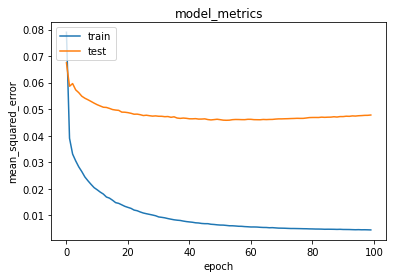

In [45]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### **6.2.2 Menampilkan rekomendasi buku dari salah satu sampel pengguna**

In [50]:
books_df = books
df_uji = df
 
# Mengambil sample user
user_id = df_uji.user_id.sample(1).iloc[0]
books_read_by_user = df_uji[df_uji.user_id == user_id]

books_not_read = books_df[~books_df['isbn'].isin(books_read_by_user.isbn.values)]['isbn'] 
books_not_read = list(
    set(books_not_read)
    .intersection(set(isbn_to_isbn_encoded.keys()))
)

books_not_read = [[isbn_to_isbn_encoded.get(x)] for x in books_not_read]
user_encoder = user_to_user_encoded.get(user_id)
user_books_array = np.hstack(
    ([[user_encoder]] * len(books_not_read), books_not_read)
)

In [51]:
# Menampilkan Top-N rekomendasi buku
ratings = model.predict(user_books_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_books_ids = [
    isbn_encoded_to_isbn.get(books_not_read[x][0]) for x in top_ratings_indices
]
 
print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Books with high ratings from user')
print('----' * 8)
 
top_books_user = (
    books_read_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .isbn.values
)
 
books_df_rows = books_df[books_df['isbn'].isin(top_books_user)]
for row in books_df_rows.itertuples():
    print(row.title, ':', row.category)
 
print('----' * 8)
print('Top 10 books recommendation')
print('----' * 8)
 
recommended_books = books_df[books_df['isbn'].isin(recommended_books_ids)]
for row in recommended_books.itertuples():
    print(row.title, ':', row.category)

Showing recommendations for users: 194600
Books with high ratings from user
--------------------------------
The Art of Mending : A Novel (Berg, Elizabeth) : ['Fiction']
Larry's Party : ['Fiction']
One True Thing : ['Fiction']
Lady Chatterley's Lover : ['Fiction']
The Kid: What Happened After My Boyfriend and I Decided to Go Get Pregnant : An Adoption Story : ['Biography & Autobiography']
--------------------------------
Top 10 books recommendation
--------------------------------
Sunshine Sketches of a Little Town (New Canadian Library) : ['Humor']
Real Live Nude Girl: Chronicles of Sex-Positive Culture : ['Health & Fitness']
The Authoritative Calvin and Hobbes (Calvin and Hobbes) : ['Humor']
Not Without My Daughter : ['Biography & Autobiography']
Illusions: The Adventures of a Reluctant Messiah : ['Fiction']
Change Your Life Without Getting Out of Bed : The Ultimate Nap Book : ['Self-Help']
Uncle John's Supremely Satisfying Bathroom Reader (Uncle John's Bathroom Reader) : ['Humor']
T